# This notebook will remake some of the figures from the paper, for the real data.  

First step: basic imports, along with some `rcParams` settings to make plots look nicer (to my eye).

The only file you will need to run this notebook is `calc_nonlin_coefs.py`.

In [1]:
import numpy as np
import calc_nonlin_coefs as nonlin
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import interpolate, stats

from matplotlib import rcParams

rcParams['font.size'] = 16
rcParams['savefig.facecolor'] = 'white'
rcParams['axes.labelsize'] = 16
rcParams['xtick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['ytick.minor.visible'] = True
rcParams['lines.linewidth'] = 3

Read in the ramps and cast to floating point: data shape is (nramps, nreads, npixels).  Then sort the ramps by their count rates and estimate the count rates.

In [2]:
ramps = fits.open('285ramps_50pixels.fits')[0].data.astype(float)

# Sort by the count rate in the first pixel.
diffs = (ramps[:, 10, 0] - ramps[:, 0, 0])/10
isort = np.argsort(diffs)
ramps_sorted = ramps*1.
for i in range(ramps.shape[0]):
    ramps_sorted[i] = ramps[isort[i]]

# List the typical count rates of these ramps.
print((np.median(ramps_sorted[:, 10] - ramps_sorted[:, 0], axis=1)/10).astype(int))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    1
    0   88   87   89   88   92   89   88   93   98   97   93   93   91
   93  101  101  101   98   97  101  106  101  103  102  104  104  101
  103  105  102  109  106  105  109  109  109  104  106  110  110  109
  109  110  110  123  123  120  126  128  126  150  154  156  152  158
  165  166  169  175  169  185  185  867  879  869  877  894  890  890
  892  891  890  905  922  904  926  927  930  922  927  932  931  977
  977  976  976 1564 1559 1561 1562 1562 1561 1562 1556 1561 1561 1560
 1558 

Use dark frames (with almost no counts) to estimate a pedestal/bias value.

In [3]:
isdark = np.abs(ramps[:, -1] - ramps[:, 0]) < 50

pedestal = np.zeros(ramps[0, 0].shape)
for i in range(pedestal.shape[0]):
    # One for dark frames, NaN if not.
    ii = isdark[:, i]/isdark[:, i]
    pedestal[i] = np.nanmedian(ramps[:, :, i]*ii[:, None])

/var/folders/p6/l404q8fx5mv4ybbxfzb2wdtm0005r2/T/ipykernel_29946/848716404.py:6: RuntimeWarning: invalid value encountered in divide
  ii = isdark[:, i]/isdark[:, i]


Parameters that we will use for the plots.  You can change the boolean variables `show_rel` and `plot_many` to make the plot look different.

Note that there are some hardcoded lines and somewhat inelegant constructs here.  This code is not meant to generalize beyond the specific case at hand.

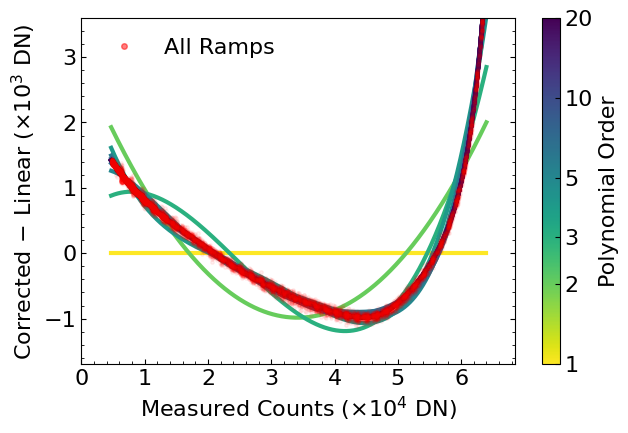

<Figure size 640x480 with 0 Axes>

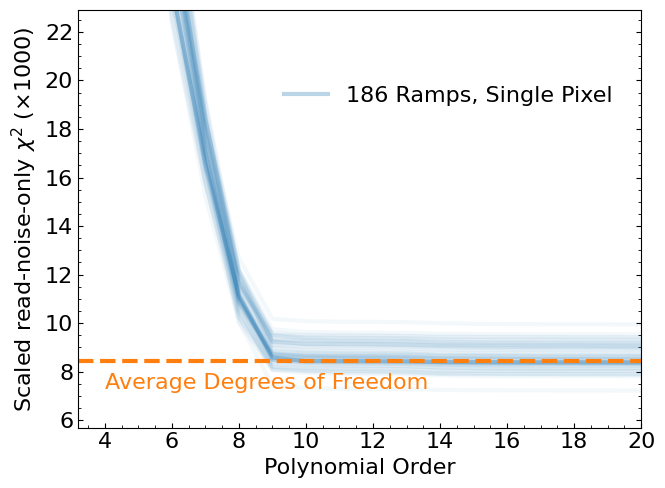

In [4]:
ipix = 15          # This is the pixel we will use for our plots.

show_rel = True    # Plot things relative to the linear fit?
plot_many = True   # Plot all ramps at once?
max_order = 20     # Maximum polynomial order
satval = 6.4e4     # Adopted saturation value: we fit everything up to this level.
readstart = 0      # First read (indexed from zero) that we use
iramp = 100        # If we plot the residuals for just one ramp, which one?

sig = 5*np.ones(pedestal.shape)   # Single-read read noise
gain = 1.8*np.ones(pedestal.shape)   # Gain (electrons/DN)

# Set this to True if we want to omit photon noise from the covariance matrix
# for the purposes of computing the nonlinearity correction.
readnoiseonly = True
if readnoiseonly:
    gain = np.inf
    
    # The line below will get the reduced chi squared to remain near 1.
    # It will not change the nonlinearity correction itself.
    sig *= 7.7

ramps = ramps_sorted[:, readstart:]

if show_rel:
    fig, (ax) = plt.subplots(1, 1, figsize=(7, 4.5))
    fac = 10
else:
    fig, (ax) = plt.subplots(1, 1)
    fac = 1

ref = 0
chisq_list = []
order_list = []

for order in np.arange(1, max_order + 1):

    # Fit for the nonlinearity parameter twice.  First, so that we
    # get a reasonably good estimate of the count rates in order to
    # get the covariance matrices right, then a second time to get
    # the answer.  
    # Use only the illuminated frames, excluding the dark frames
    # at the beginning.  The dark frames can be used to measure the
    # read noise.
    
    ramps_illum = ramps[99:]*1.
    
    res = nonlin.get_nonlin_coefs(ramps_illum, sig, gain, order, pedestal,
                                   satval=satval)

    res = nonlin.get_nonlin_coefs(ramps_illum, sig, gain, order, pedestal,
                                   satval=satval, last_pars=res)

    coefs = res.nonlin_coefs[ipix]

    order_list += [res.order]
    chisq_list += [res.chisq]

    # We will plot the fit on this domain.
    # Compute the correction polynomial.
    xmodel = np.linspace(pedestal[ipix], satval, 1000).astype(float)
    xmodel_rel = xmodel - pedestal[ipix]
    
    ymodel = coefs[order - 1]
    for i in range(order - 2, -1, -1):
        ymodel = ymodel*xmodel_rel + coefs[i]

    ymodel = ymodel*xmodel_rel + pedestal[ipix]

    # Color code the line by the order of the fit.
    cval = plt.cm.viridis_r([np.log(order)/np.log(max_order)])

    # This is to plot the ramps and models relative to the linear fits.
    if order == 1 and show_rel:
        ref = ymodel/1e4
        reflist = [(ramps_illum[ir, :, ipix] - pedestal[ipix])*coefs[0]/1e4 
                  for ir in range(len(ramps_illum))]
            
    elif not show_rel:
        reflist = [0 for i in range(ramps_illum.shape[0])]

    if show_rel:
        ymodel = (ymodel - np.mean(ymodel))/1e4 - (ref - np.mean(ref))
    else:
        ymodel = ymodel/1e4

    f = ax.plot(xmodel/1e4, ymodel*fac, c=cval)

# The nonlinearity correction does not derive an offset/reset value for
# each ramp.  We'll get that by just taking the mean difference between
# the model and data, where we need to interpolate the model.

f_interp = interpolate.interp1d(xmodel/1e4, ymodel, kind='cubic',
                                bounds_error=False, fill_value=np.nan)

# If we are plotting just one ramp
if not plot_many:
    slope = res.slopes[ipix, iramp]
    _x = ramps_illum[iramp, :, ipix]/1e4
    
    _y = (pedestal[ipix] + slope*np.arange(1, ramps_illum.shape[1] + 1))/1e4 - reflist[iramp]
    offset = np.nanmean((f_interp(_x) - _y)[:30])

    ax.plot(_x, fac*(_y + offset), 
            marker='o', linestyle='', color='r',
            markersize=4.5, label='One Ramp')

# If we are plotting all ramps at once
else:
    labeled = False
    for ir in range(ramps_illum.shape[0] - 1, -1, -1):

        # Don't plot dark frames
        slope = res.slopes[ipix, ir]
        if slope < 10:
            continue
        
        _x = ramps_illum[ir, :, ipix]/1e4
        _y = (pedestal[ipix] + slope*np.arange(1, ramps_illum.shape[1] + 1))/1e4 - reflist[ir]

        # For this offset (just for plotting), use the first 30 reads.
        offset = np.nanmean((f_interp(_x) - _y)[:30])

        # A bit of a hack to draw a label on the plot
        if labeled == False:
            ax.plot(_x[0], fac*(_y[0] + offset), marker='o', linestyle='',
                    color='r', markersize=4, alpha=0.5, label='All Ramps')
            labeled = True
            
        ax.plot(_x, fac*(_y + offset), marker='o', linestyle='',
                color='r', markersize=2.5, alpha=0.06)

# Add a color bar and make the plot

sm = plt.cm.ScalarMappable(cmap='viridis_r')
cb = plt.colorbar(sm, ax=ax, label="Polynomial Order", cmap='viridis_r')

locs = np.array([1, 2, 3, 5, 10, 20, 30, 50])
locs = list(locs[locs <= max_order])
ax.set_xticks(np.arange(7))
cb.set_ticks([], minor=True)
cb.set_ticks(np.log(locs)/np.log(max_order), labels=locs)
ax.set_xlabel("Measured Counts ($\\times$10$^4$ DN)")
if show_rel:
    ax.set_ylim(-1.7, 3.6)
    ax.set_ylabel("Corrected$\,-\,$Linear ($\\times$10$^3$ DN)")
else:
    ax.set_yticks(np.arange(8))
    ax.set_ylim(-0.25, 7.95)
    ax.set_ylabel("Corrected Counts ($\\times$10$^4$ DN)")
plt.legend(frameon=False)
    
plt.show()
plt.clf()

# Now make a plot of chi squared for all pixels as a function of 
# polynomial order.

chisq = np.asarray(chisq_list)
fig, (ax) = plt.subplots(1, 1)
for i in range(chisq.shape[1]):
    if i == 0:
        lab = '%d Ramps, Single Pixel' % (ramps_illum.shape[0])
        ax.plot(order_list, 1e-3*chisq[:, i], color='C0', alpha=0.3, label=lab)
    else:
        ax.plot(order_list, 1e-3*chisq[:, i], color='C0', alpha=0.05)

offset = 0.5
ax.text(4, 1e-3*np.sum(ramps_illum[:, 2:, 0] < satval) - offset,
         'Average Degrees of Freedom',
         horizontalalignment='left', verticalalignment='top', color='C1')
ax.axhline(y=1e-3*np.sum(ramps_illum[:, 2:, 0] < satval), color='C1', linestyle='--')

ax.legend(frameon=False, loc=(0.35, 0.75))
ax.set_xlabel("Polynomial Order")
ax.set_ylabel(r"Scaled read-noise-only $\chi^2$ ($\times 1000$)")

ax.set_ylim(5.7, 22.9)
ax.set_xlim(3.2, max_order)
ax.set_xticks(np.arange(4, max_order + 1, 2))
plt.subplots_adjust(left=0.11, bottom=0.12, right=0.99, top=0.99)

plt.show()